In [183]:
import os, os.path as osp
from glob import glob
from natsort import os_sorted
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm  

In [184]:
# Input folder data
input_dir = 'SSC'

# split train folder into train and validation
split_train = 0.8

# Parameter for data segmentation
frame_len = 16  #จำนวน frame ต่อ 1 ชุดข้อมูล  2940 // ใช้ 100
hop_len = 8 # ระยะเหลื่อมระหว่าง frame 2940 // ใช้ 100

'''  Example
    --------
frame_len = 3
hop_len = 2

x = np.array([
    [0, 1, 2],
    [10, 11, 12],
    [20, 21, 22],
    [30, 31, 32],
    [40, 41, 42],
    [50, 51, 52],
    [60, 61, 62],
    [70, 71, 72]
])

📌 เฟรมที่ 1:
[[ 0  1  2]
 [10 11 12] 
 [20 21 22]]

📌 เฟรมที่ 2:
[[20 21 22]
 [30 31 32]
 [40 41 42]]

📌 เฟรมที่ 3:
[[40 41 42]
 [50 51 52]
 [60 61 62]]
'''


'  Example\n    --------\nframe_len = 3\nhop_len = 2\n\nx = np.array([\n    [0, 1, 2],\n    [10, 11, 12],\n    [20, 21, 22],\n    [30, 31, 32],\n    [40, 41, 42],\n    [50, 51, 52],\n    [60, 61, 62],\n    [70, 71, 72]\n])\n\n📌 เฟรมที่ 1:\n[[ 0  1  2]\n [10 11 12] \n [20 21 22]]\n\n📌 เฟรมที่ 2:\n[[20 21 22]\n [30 31 32]\n [40 41 42]]\n\n📌 เฟรมที่ 3:\n[[40 41 42]\n [50 51 52]\n [60 61 62]]\n'

In [185]:
train_dir = input_dir + '/train'
test_dir = input_dir + '/test'
df_paths = glob(osp.join(train_dir, '*', '*.csv'))

In [186]:
def plot_activity(activity,df,start=0,stop=-1):
    df = df.iloc[start:stop]

    ax = df.plot(subplots=True,figsize=(16,12),title=activity+ ', Start Row: '+str(start)+' Stop row: '+str(stop)) # Plot accelerometer for the activity.
    for a in ax:
        a.legend(loc='upper right')

# All data

##### BVP : ชีพจรปริมาตรเลือดที่ได้จากเซ็นเซอร์ PPG
##### ACC : การวัดความเร่งแบบสามแกน (Triaxial Accelerometry) โดยแต่ละแกนถูกกำหนดชื่อเป็น ACC_X, ACC_Y, ACC_Z
##### TEMP (°C) : อุณหภูมิผิวหนังที่วัดจากอินฟราเรด
##### EDA (μS) : กิจกรรมทางไฟฟ้าของผิวหนังจากเซ็นเซอร์วัดการตอบสนองทางเหงื่อ (Galvanic Skin Response)
##### HR (bpm) : อัตราการเต้นของหัวใจ (Heart Rate) ที่ประมาณจากค่า BVP
##### IBI (ms) : ช่วงเวลาระหว่างจังหวะการเต้นของหัวใจแต่ละครั้ง

In [187]:
full_dir = 'train' + '/train'
df_full = glob(osp.join(full_dir, '*.csv'))

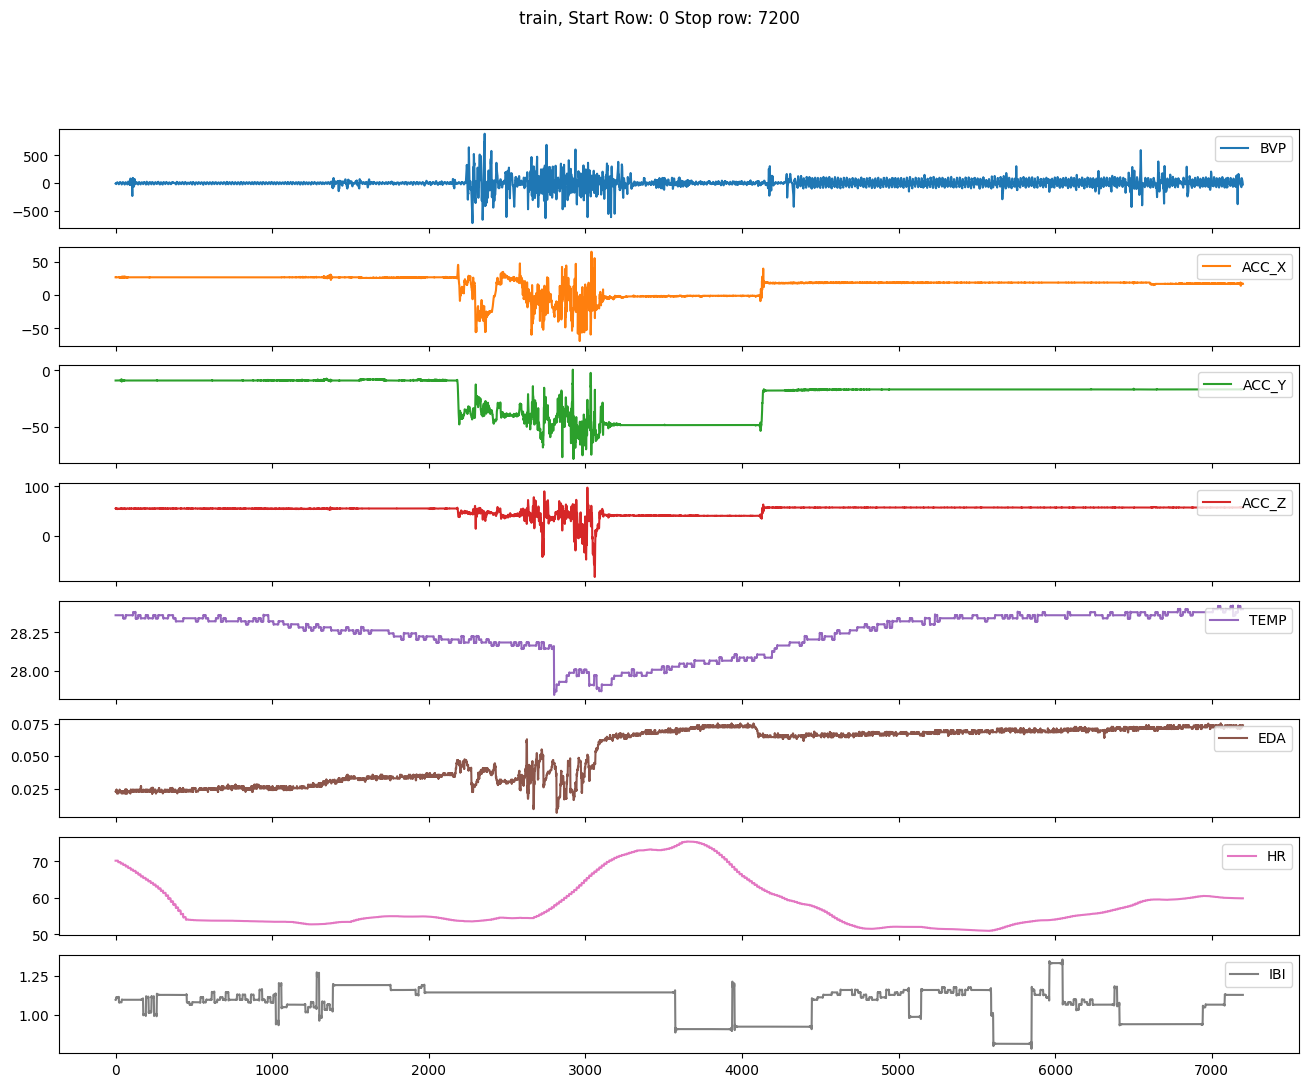

In [188]:
path = df_full[6]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df, 0, 240 * 30)

# split Data

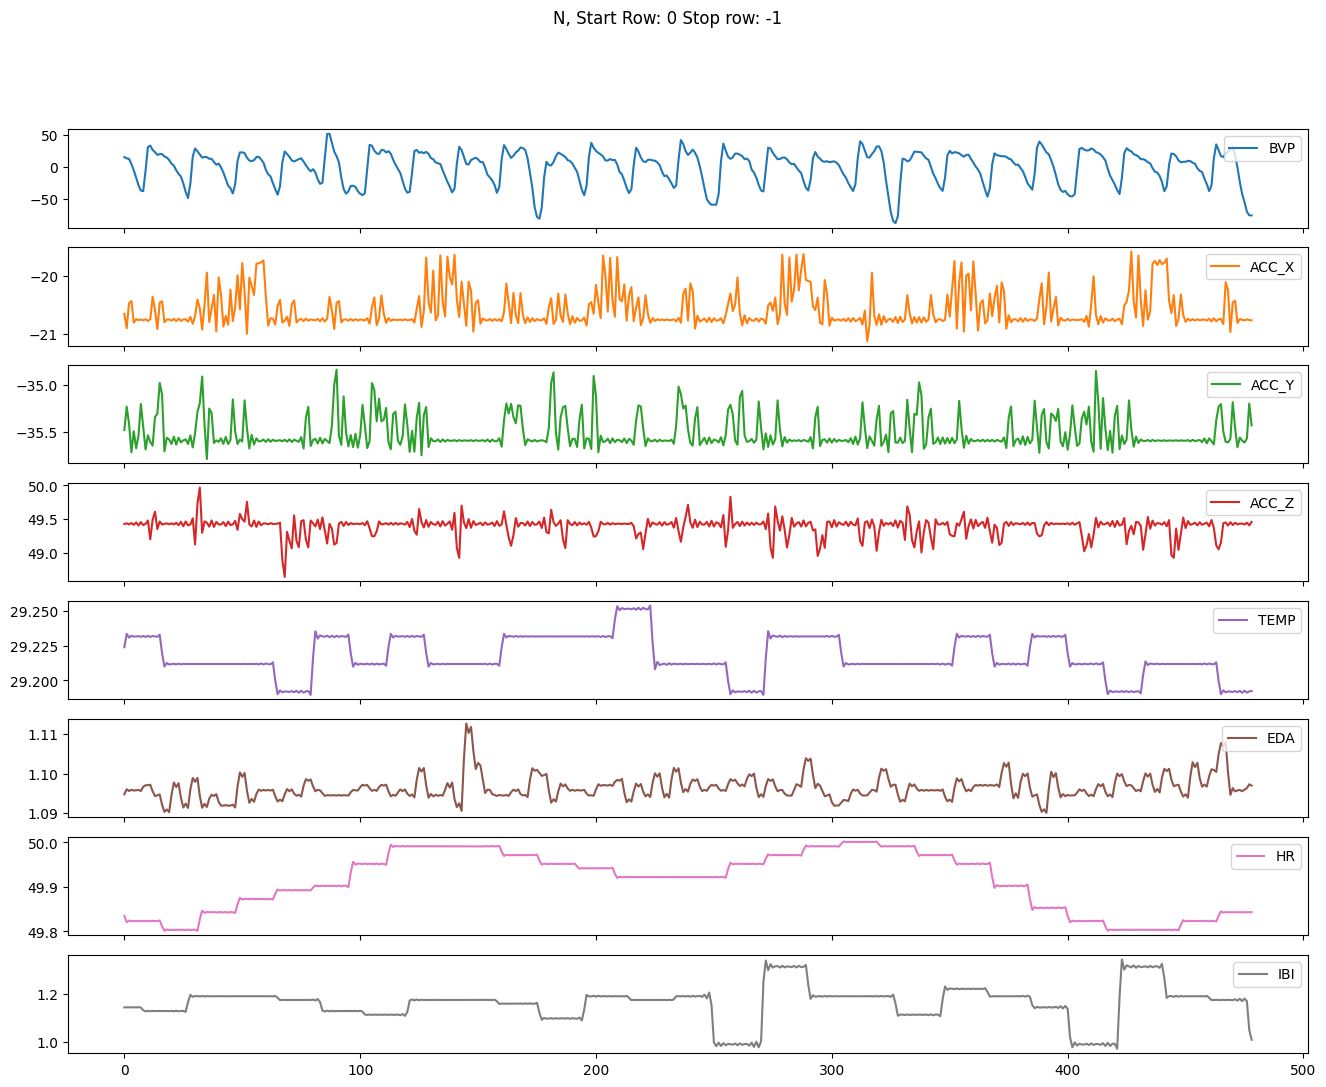

In [189]:
path = df_paths[5000]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

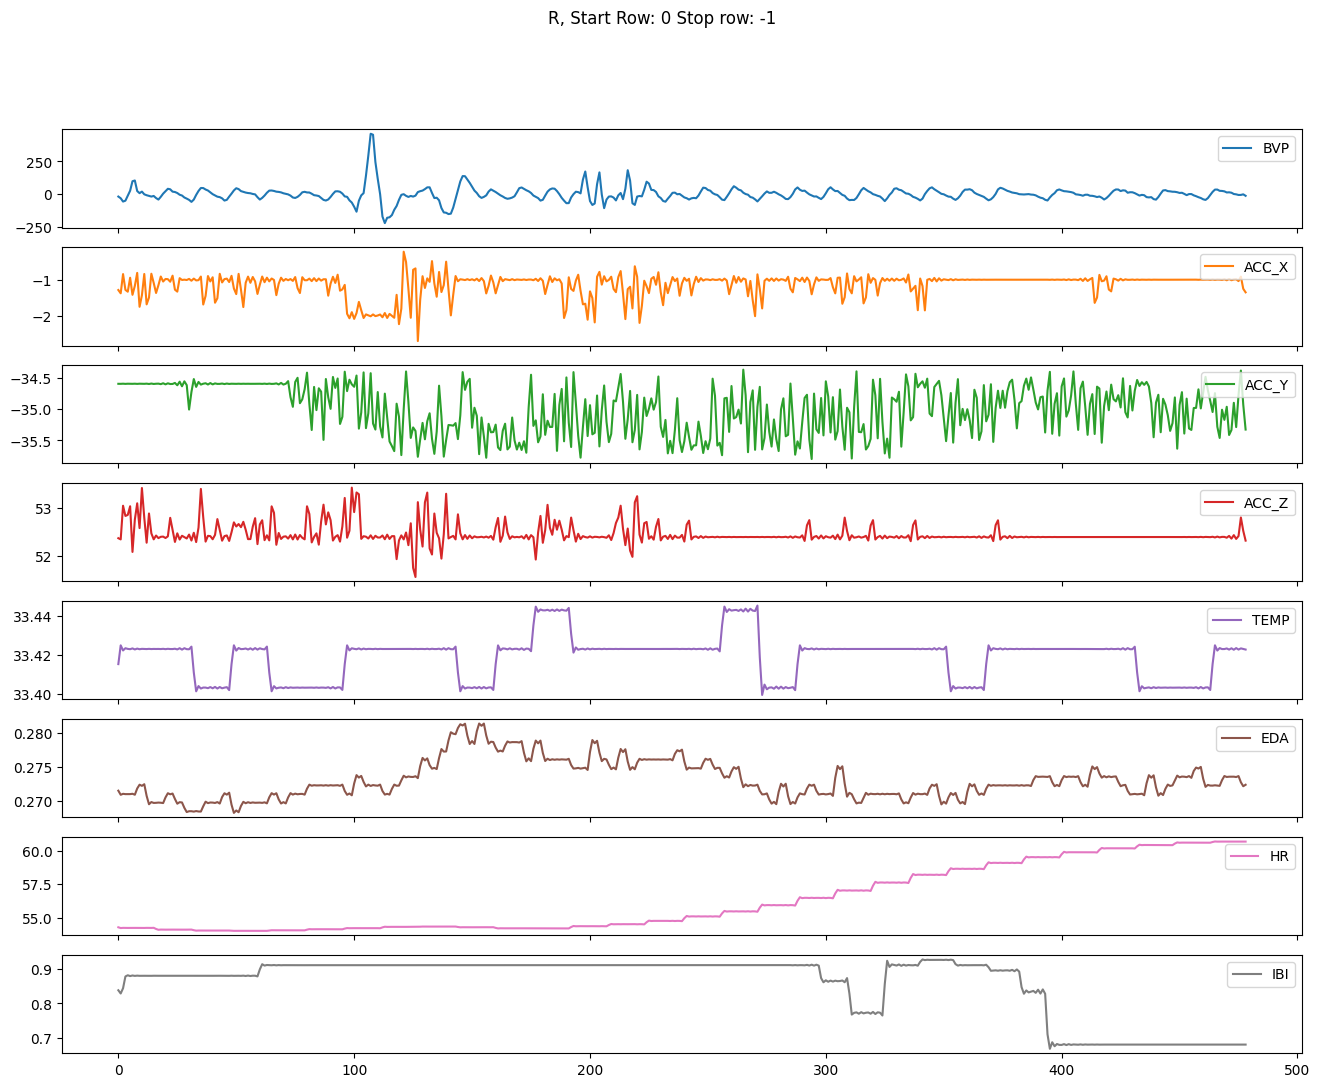

In [193]:
path = df_paths[50000]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

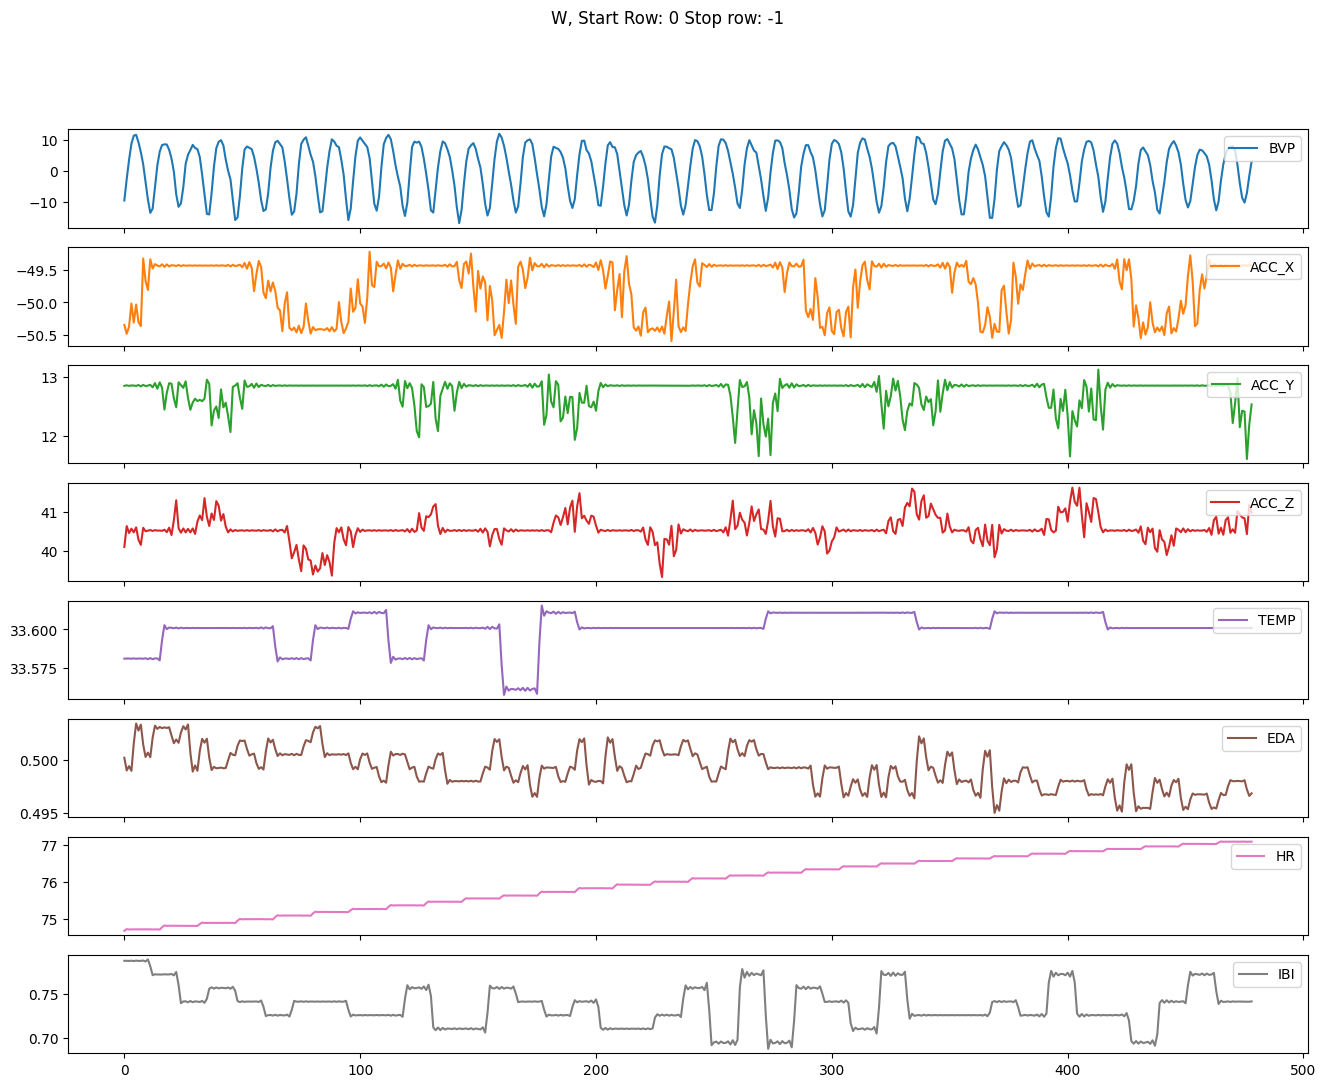

In [191]:
path = df_paths[60000]
normalized_path = path.replace("\\", "/")  
activity, filename = normalized_path.split('/')[-2:]
df = pd.read_csv(path)
plot_activity(activity, df)

In [194]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import glob
dataset_paths = {'train': [], 'val': []}

for activity_dir in tqdm(glob.glob(osp.join(train_dir, '*')), desc="Processing Directories"):
    paths = glob.glob(osp.join(activity_dir, '*.csv'))
    train_paths, val_paths = train_test_split(paths, test_size=0.2 , random_state=42)
    dataset_paths['train'].extend(train_paths)
    dataset_paths['val'].extend(val_paths)

Processing Directories: 100%|██████████| 3/3 [00:00<00:00, 14.16it/s]


In [195]:
print("Train Files:", len(dataset_paths['train']))
print("Val Files:", len(dataset_paths['val']))

Train Files: 53177
Val Files: 13296


In [196]:
def frame(x, frame_len, hop_len):

    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)
    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

In [165]:
dataset_blocks = {'train': {'block': [], 'label': []},
                  'val': {'block': [], 'label': []}}

for dataset in ['train', 'val']:
    paths = dataset_paths[dataset]

    # ใช้ tqdm เพื่อแสดง Progress Bar ขณะอ่านไฟล์
    for path in tqdm(paths, desc=f"Processing {dataset} Dataset"):
        activity = path.split(os.sep)[-2]
        df = pd.read_csv(path)

        # Preprocessing
        mms = StandardScaler()
        for feature in list(df.columns):
            df[feature] = mms.fit_transform(df[[feature]])

        samples = frame(df.loc[:, ].values, frame_len, hop_len)
        labels = np.full(samples.shape[0], activity)

        dataset_blocks[dataset]['block'].extend(samples)
        dataset_blocks[dataset]['label'].extend(labels)

    dataset_blocks[dataset]['block'] = np.array(dataset_blocks[dataset]['block'])
    dataset_blocks[dataset]['label'] = np.array(dataset_blocks[dataset]['label'])

print("✅ Preprocessing เสร็จสิ้นสำหรับทั้ง train และ val datasets!")


Processing val Dataset: 100%|██████████| 5000/5000 [01:25<00:00, 58.32it/s]


✅ Preprocessing เสร็จสิ้นสำหรับทั้ง train และ val datasets!


In [166]:
dataset_blocks['train']['block'].shape, dataset_blocks['val']['block'].shape

((590000, 8, 8), (295000, 8, 8))

In [167]:
dataset_blocks['val']['label'][:10]

array(['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N'], dtype='<U1')

In [178]:
LABELS = os_sorted([osp.split(path)[-1] for path in glob(osp.join(train_dir, '*'))])
LABELS

['N', 'R', 'W']

In [ ]:
# LABELS = ['N', 'R', 'W'] # ถ้าตัวบนใช้ไม่ได้ให้ใช้ตัวนี้

In [173]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']
    one_hot_encoded = np.zeros((labels.size, len(LABELS)))

    for i, label in enumerate(LABELS):
        index = np.where(labels == label)[0]
        one_hot_encoded[index, i] = 1

    dataset_blocks[dataset]['label'] = one_hot_encoded

### W = Wake ช่วงตื่น
### N = Non-REM การนอนหลับแบบไม่มีฝัน
### R = REM การนอนหลับแบบฝัน หายากที่สุด เพราะใช้เวลาน้อยที่สุดในรอบการนอนหลับ

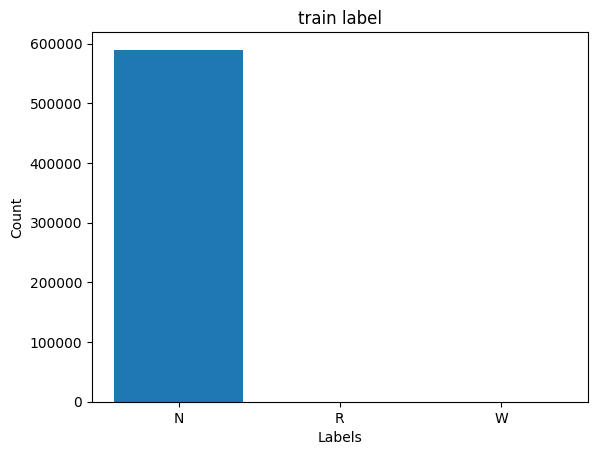

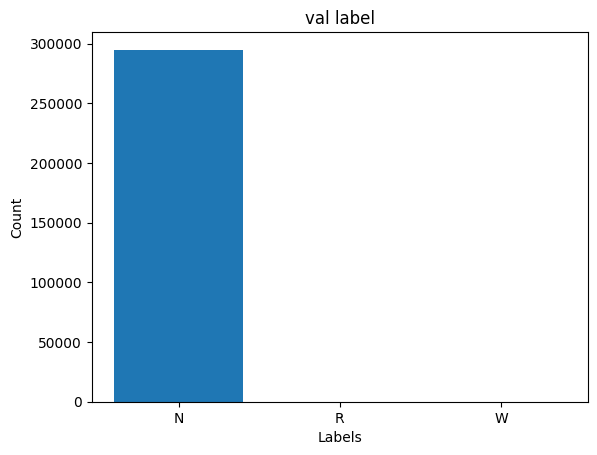

In [174]:
for dataset in ['train', 'val']:
    labels = dataset_blocks[dataset]['label']

    labels_sum = labels.sum(axis=0)

    plt.bar(LABELS, labels_sum) 
    plt.title(f'{dataset} label')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

In [175]:
X_train = dataset_blocks['train']['block']
Y_train = dataset_blocks['train']['label']

n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], Y_train.shape[1]
print('n_timesteps: {}, n_features: {}, n_outputs: {}'.format(n_timesteps,n_features,n_outputs))

n_timesteps: 8, n_features: 8, n_outputs: 3


In [181]:
import keras
from keras.layers import Conv1D, MaxPooling1D, Input, Dense, Dropout, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SpatialDropout1D
from keras import regularizers

In [ ]:
model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

model.add(Conv1D(256, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.3))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))  
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))

model.add(Dense(n_outputs, activation='softmax'))
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 8, 256)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ (None, 8, 256)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 8, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 4, 256)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 4, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 2, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 958,083 (3.65 MB)

 Trainable params: 957,571 (3.65 MB)

 Non-trainable params: 512 (2.00 KB)

In [182]:
model = Sequential()
model.add(Input(shape=(n_timesteps, n_features)))

# เพิ่มเลเยอร์ Conv1D พร้อมการกรองเสียงรบกวน
model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same', 
                 kernel_regularizer=regularizers.l2(0.01)))  # ใช้ L2 Regularization
model.add(BatchNormalization())
model.add(SpatialDropout1D(0.3))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))  # ใช้ L2 Regularization
model.add(AveragePooling1D(pool_size=2))

model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same',
                 kernel_regularizer=regularizers.l2(0.01)))  # ใช้ L2 Regularization
model.add(MaxPooling1D(pool_size=2))

# ใช้ Bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))

# เพิ่มเลเยอร์ Dense สำหรับการจำแนกประเภท
model.add(Dense(n_outputs, activation='softmax'))

# แสดงสรุปโมเดล
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 8, 256)         │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ (None, 8, 256)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 8, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 4, 256)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 4, 256)         │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 2, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 960,131 (3.66 MB)

 Trainable params: 959,619 (3.66 MB)

 Non-trainable params: 512 (2.00 KB)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath= 'best_cnn_model.weights.h5',
        monitor='val_loss', save_best_only=True, save_weights_only=True
    ),
]

epochs = 10
batch_size = 32

In [ ]:
history = model.fit(dataset_blocks['train']['block'],
                    dataset_blocks['train']['label'],
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(dataset_blocks['val']['block'],
                                     dataset_blocks['val']['label']),
                    callbacks=callbacks_list,
                    verbose=1)